---
**License**

 NC_Colossus_density_profiles

 Mon Jun 01 09:20:00 2020\
 Copyright  2020\
 Sandro Dias Pinto Vitenti <vitenti@uel.br>

---
---

 NC_Colossus_density_profiles\
 Copyright (C) 2020 Sandro Dias Pinto Vitenti <vitenti@uel.br>

 numcosmo is free software: you can redistribute it and/or modify it
 under the terms of the GNU General Public License as published by the
 Free Software Foundation, either version 3 of the License, or
 (at your option) any later version.

 numcosmo is distributed in the hope that it will be useful, but
 WITHOUT ANY WARRANTY; without even the implied warranty of
 MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.
 See the GNU General Public License for more details.

 You should have received a copy of the GNU General Public License along
 with this program.  If not, see <http://www.gnu.org/licenses/>.
 
---

In [1]:
try:
  import gi
  gi.require_version('NumCosmo', '1.0')
  gi.require_version('NumCosmoMath', '1.0')
except:
  pass

from gi.repository import GObject
from gi.repository import NumCosmo as Nc
from gi.repository import NumCosmoMath as Ncm

from colossus.cosmology import cosmology
from colossus.halo import profile_nfw
from colossus.halo import profile_einasto
from colossus.halo import profile_hernquist
from colossus.halo import mass_so
from colossus.utils import constants

import sys
import numpy as np
import math
import matplotlib.pyplot as plt


In [2]:
#params = cosmology.cosmologies['planck18']
#params['de_model'] = 'w0wa'
#params['w0'] = -0.8
#params['wa'] = 0.1
##params['interpolation'] = False
#params['persistence'] = ''

#cosmo_col = cosmology.setCosmology('planck_w0wa', params)
cosmo_col = cosmology.setCosmology('planck18');

Ncm.cfg_init ()
Ncm.cfg_set_log_handler (lambda msg: sys.stdout.write (msg) and sys.stdout.flush ())

In [3]:
cosmo = Nc.HICosmo.new_from_name (Nc.HICosmo, "NcHICosmoDEXcdm{'massnu-length':<0>}")
#cosmo = Nc.HICosmo.new_from_name (Nc.HICosmo, "NcHICosmoDECpl{'massnu-length':<0>}")
cosmo.omega_x2omega_k ()
cosmo.param_set_by_name ("H0",        cosmo_col.H0)
cosmo.param_set_by_name ("Omegak",    cosmo_col.Ok(0.0))
cosmo.param_set_by_name ("w",         cosmo_col.w0)
#cosmo.param_set_by_name ("w1",        cosmo_col.wa)
cosmo.param_set_by_name ("Omegab",    cosmo_col.Ob0)
cosmo.param_set_by_name ("Omegac",    (cosmo_col.Om0 - cosmo_col.Ob0))
#cosmo.param_set_by_name ("massnu_0",  Planck13.m_nu.value[2])
#cosmo.param_set_by_name ("ENnu",      cosmo_col.Neff - 3.0 * cosmo.E2Press_mnu (1.0e10) / (cosmo.E2Omega_g (1.0e10) * (7 / 8 * (4 / 11)**(4 / 3))))
cosmo.param_set_by_name ("ENnu",      cosmo_col.Neff)
cosmo.param_set_by_name ("Tgamma0",   cosmo_col.Tcmb0)


In [4]:
def cmp_double (desc, m1, m2, x1, x2):
    print ("%s: %s = % 22.15g, %s = % 22.15g, CMP: %9.2e" % (desc, m1, x1, m2, x2, math.fabs (x1 / x2 - 1.0)))

In [5]:
Mvir  = 1.0e15
cvir  = 5.0
z     = 0.2
alpha = 0.25

# Colossus
col_nfw = profile_nfw.NFWProfile (M = Mvir, c = cvir, z = z, mdef = 'vir')
col_ein = profile_einasto.EinastoProfile (M = Mvir, c = cvir, z = z, mdef = 'vir', alpha = alpha)
col_her = profile_hernquist.HernquistProfile (M = Mvir, c = cvir, z = z, mdef = 'vir')

In [6]:
# NumCosmo
reltol = 1.0e-9
lnXi   = math.log (1.0e-4)
lnXf   = math.log (1.0e+4)
improve_prec = True

nc_nfw = Nc.HaloDensityProfileNFW.new (Nc.HaloDensityProfileMassDef.VIRIAL, 200.0) 
nc_nfw.param_set_by_name ('cDelta', cvir) 
nc_nfw.param_set_by_name ('MDelta', Mvir / cosmo.h ())

if improve_prec:
    nc_nfw.set_reltol (reltol) 
    nc_nfw.set_lnXi (lnXi)
    nc_nfw.set_lnXf (lnXf)

nc_ein = Nc.HaloDensityProfileEinasto.new (Nc.HaloDensityProfileMassDef.VIRIAL, 200.0)
nc_ein.param_set_by_name ('cDelta', cvir) 
nc_ein.param_set_by_name ('MDelta', Mvir / cosmo.h ())
nc_ein.param_set_by_name ('alpha', alpha)

if improve_prec:
    nc_ein.set_reltol (reltol) 
    nc_ein.set_lnXi (lnXi)
    nc_ein.set_lnXf (lnXf)

nc_her = Nc.HaloDensityProfileHernquist.new (Nc.HaloDensityProfileMassDef.VIRIAL, 200.0)
nc_her.param_set_by_name ('cDelta', cvir) 
nc_her.param_set_by_name ('MDelta', Mvir / cosmo.h ())

if improve_prec:
    nc_her.set_reltol (reltol) 
    nc_her.set_lnXi (lnXi)
    nc_her.set_lnXf (lnXf)

smd = Nc.WLSurfaceMassDensity.new (Nc.Distance.new (5.0))
smd.prepare (cosmo)

**Comparing NFW, Einasto and Hernquist profiles $\rho(r) /\rho_m$**

In [7]:
r     = 10**np.arange (-1, +4, 0.02)
rho_m = cosmo_col.rho_m (z)

(col_rhos, col_rs) = col_nfw.fundamentalParameters (Mvir, cvir, z, 'vir')
(nc_rs, nc_rhos)   = nc_nfw.r_s_rho_s (cosmo, z)

cmp_double ("NFW:rhos", "Colossus", "NumCosmo", col_rhos, nc_rhos / (cosmo.h2 () * 1.0e9))
cmp_double ("NFW:rs  ", "Colossus", "NumCosmo", col_rs, nc_rs * (cosmo.h () * 1.0e3))

col_ein.fundamentalParameters (Mvir, cvir, z, 'vir', alpha = alpha)
(col_rhos, col_rs) = (col_ein.par['rhos'], col_ein.par['rs'])
(nc_rs, nc_rhos)   = nc_ein.r_s_rho_s (cosmo, z)

cmp_double ("EIN:rhos", "Colossus", "NumCosmo", col_rhos, nc_rhos / (cosmo.h2 () * 1.0e9))
cmp_double ("EIN:rs  ", "Colossus", "NumCosmo", col_rs, nc_rs * (cosmo.h () * 1.0e3))

(col_rhos, col_rs) = col_her.fundamentalParameters (Mvir, cvir, z, 'vir')
(nc_rs, nc_rhos)   = nc_her.r_s_rho_s (cosmo, z)

cmp_double ("HER:rhos", "Colossus", "NumCosmo", col_rhos, nc_rhos / (cosmo.h2 () * 1.0e9))
cmp_double ("HER:rs  ", "Colossus", "NumCosmo", col_rs, nc_rs * (cosmo.h () * 1.0e3))


NFW:rhos: Colossus =        1765365.0425405, NumCosmo =       1765365.04514365, CMP:  1.47e-09
NFW:rs  : Colossus =       360.965466546044, NumCosmo =       360.965466368622, CMP:  4.92e-10
EIN:rhos: Colossus =       457347.081703932, NumCosmo =       457347.082378321, CMP:  1.47e-09
EIN:rs  : Colossus =       360.965466546044, NumCosmo =       360.965466368622, CMP:  4.92e-10
HER:rhos: Colossus =       4872879.34895724, NumCosmo =       4872879.35614263, CMP:  1.47e-09
HER:rs  : Colossus =       360.965466546044, NumCosmo =       360.965466368622, CMP:  4.92e-10


<Figure size 432x288 with 0 Axes>

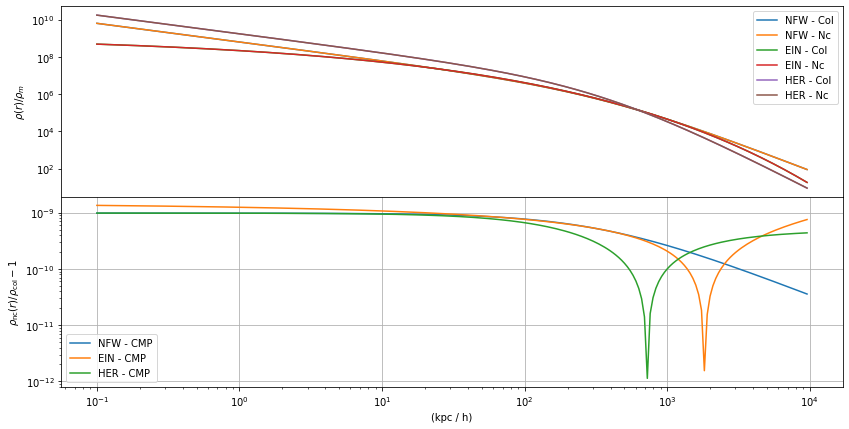

In [8]:
col_rho_nfw = col_nfw.density (r)
col_rho_ein = col_ein.density (r)
col_rho_her = col_her.density (r)

nc_rho_nfw  = np.array (nc_nfw.eval_density_array (cosmo, r, 1.0e-3 / cosmo.h (), 1.0 / (cosmo.h2 () * 1.0e9), z))
nc_rho_ein  = np.array (nc_ein.eval_density_array (cosmo, r, 1.0e-3 / cosmo.h (), 1.0 / (cosmo.h2 () * 1.0e9), z))
nc_rho_her  = np.array (nc_her.eval_density_array (cosmo, r, 1.0e-3 / cosmo.h (), 1.0 / (cosmo.h2 () * 1.0e9), z))

plt.figure()
fig, axs = plt.subplots (2, sharex=True, gridspec_kw={'hspace': 0}, figsize=(14,7))

axs[0].set_xscale ('log')
axs[0].set_yscale ('log')
axs[1].set_yscale ('log')
axs[1].set_xlabel(r'(kpc / h)')
axs[0].set_ylabel(r'$\rho (r) / \rho_m$')
axs[1].set_ylabel(r'$\rho_{\mathrm{nc}} (r) / \rho_{\mathrm{col}} - 1$')
axs[0].plot (r, col_rho_nfw, '-', label = 'NFW - Col')
axs[0].plot (r, nc_rho_nfw,  '-', label = 'NFW - Nc')
axs[0].plot (r, col_rho_ein, '-', label = 'EIN - Col')
axs[0].plot (r, nc_rho_ein,  '-', label = 'EIN - Nc')
axs[0].plot (r, col_rho_her, '-', label = 'HER - Col')
axs[0].plot (r, nc_rho_her,  '-', label = 'HER - Nc')
axs[1].plot (r, np.abs (nc_rho_nfw / col_rho_nfw - 1.0), '-', label = "NFW - CMP")
axs[1].plot (r, np.abs (nc_rho_ein / col_rho_ein - 1.0), '-', label = "EIN - CMP")
axs[1].plot (r, np.abs (nc_rho_her / col_rho_her - 1.0), '-', label = "HER - CMP")

axs[0].legend(loc='best')
axs[1].legend(loc='best')
axs[1].grid()

plt.show ()

**Comparing NFW, Einasto and Hernquist surface mass density $\Sigma (R)$**

<Figure size 432x288 with 0 Axes>

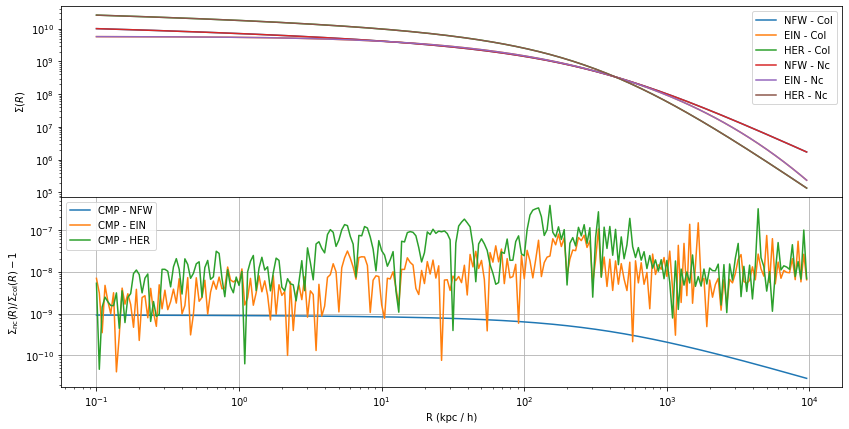

In [9]:
col_Sigma_nfw = col_nfw.surfaceDensity (r)
col_Sigma_ein = col_ein.surfaceDensity (r)
col_Sigma_her = col_her.surfaceDensity (r)

nc_Sigma_nfw  = smd.sigma_array (nc_nfw, cosmo, r, 1.0e-3 / cosmo.h (), 1.0 / (cosmo.h () * 1.0e6), z)
nc_Sigma_ein  = smd.sigma_array (nc_ein, cosmo, r, 1.0e-3 / cosmo.h (), 1.0 / (cosmo.h () * 1.0e6), z)
nc_Sigma_her  = smd.sigma_array (nc_her, cosmo, r, 1.0e-3 / cosmo.h (), 1.0 / (cosmo.h () * 1.0e6), z)

plt.figure()
fig, axs = plt.subplots (2, sharex=True, gridspec_kw={'hspace': 0}, figsize=(14,7))

axs[0].set_xscale ('log')
axs[0].set_yscale ('log')
axs[1].set_yscale ('log')
axs[1].set_xlabel('R (kpc / h)')
axs[0].set_ylabel(r'$\Sigma (R)$')
axs[1].set_ylabel(r'$\Sigma_{\mathrm{nc}} (R) / \Sigma_{\mathrm{col}} (R) - 1$')
axs[0].plot (r, col_Sigma_nfw, '-', label = 'NFW - Col')
axs[0].plot (r, col_Sigma_ein, '-', label = 'EIN - Col')
axs[0].plot (r, col_Sigma_her, '-', label = 'HER - Col')
axs[0].plot (r, nc_Sigma_nfw, '-',  label = 'NFW - Nc')
axs[0].plot (r, nc_Sigma_ein, '-',  label = 'EIN - Nc')
axs[0].plot (r, nc_Sigma_her, '-',  label = 'HER - Nc')
axs[1].plot (r, np.abs (nc_Sigma_nfw / col_Sigma_nfw - 1.0), '-', label = "CMP - NFW")
axs[1].plot (r, np.abs (nc_Sigma_ein / col_Sigma_ein - 1.0), '-', label = "CMP - EIN")
axs[1].plot (r, np.abs (nc_Sigma_her / col_Sigma_her - 1.0), '-', label = "CMP - HER")

axs[0].legend(loc='best')
axs[1].legend(loc='best')
axs[1].grid()
plt.show ()

**Comparing NFW, Einasto and Hernquist excess $\Delta\Sigma (R) = \overline\Sigma (<R) - \Sigma(R)$**

<Figure size 432x288 with 0 Axes>

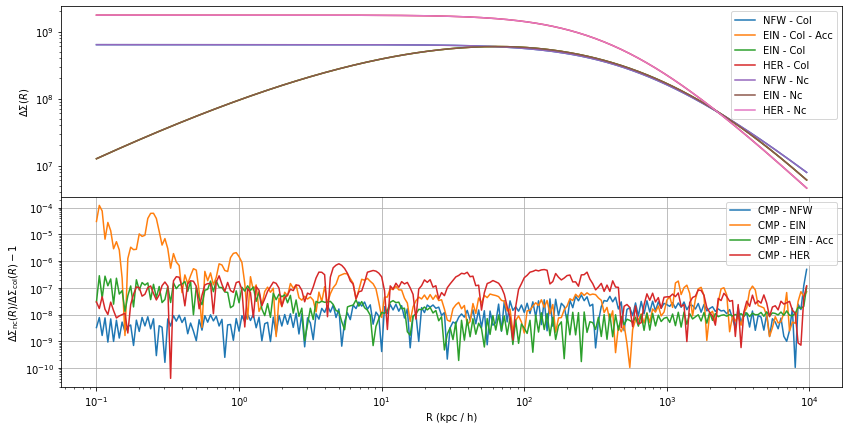

In [13]:
col_DeltaSigma_nfw  = col_nfw.deltaSigma (r)
col_DeltaSigma_ein  = col_ein.deltaSigma (r)
col_DeltaSigma_Aein = col_ein.deltaSigma (r, accuracy = 1.0e-9)
col_DeltaSigma_her  = col_her.deltaSigma (r)

nc_DeltaSigma_nfw  = np.array (smd.sigma_excess_array (nc_nfw, cosmo, r, 1.0e-3 / cosmo.h (), 1.0 / (cosmo.h () * 1.0e6), z))
nc_DeltaSigma_ein  = np.array (smd.sigma_excess_array (nc_ein, cosmo, r, 1.0e-3 / cosmo.h (), 1.0 / (cosmo.h () * 1.0e6), z))
nc_DeltaSigma_her  = np.array (smd.sigma_excess_array (nc_her, cosmo, r, 1.0e-3 / cosmo.h (), 1.0 / (cosmo.h () * 1.0e6), z))

plt.figure()
fig, axs = plt.subplots (2, sharex=True, gridspec_kw={'hspace': 0}, figsize=(14,7))

axs[0].set_xscale ('log')
axs[0].set_yscale ('log')
axs[1].set_yscale ('log')
axs[1].set_xlabel('R (kpc / h)')
axs[0].set_ylabel(r'$\Delta\Sigma(R)$')
axs[1].set_ylabel(r'$\Delta\Sigma_\mathrm{nc}(R) / \Delta\Sigma_\mathrm{col}(R) - 1$')
axs[0].plot (r, col_DeltaSigma_nfw,  '-', label = 'NFW - Col')
axs[0].plot (r, col_DeltaSigma_Aein, '-', label = 'EIN - Col - Acc')
axs[0].plot (r, col_DeltaSigma_ein,  '-', label = 'EIN - Col')
axs[0].plot (r, col_DeltaSigma_her,  '-', label = 'HER - Col')
axs[0].plot (r, nc_DeltaSigma_nfw,   '-', label = 'NFW - Nc')
axs[0].plot (r, nc_DeltaSigma_ein,   '-', label = 'EIN - Nc')
axs[0].plot (r, nc_DeltaSigma_her,   '-', label = 'HER - Nc')
axs[1].plot (r, np.abs (nc_DeltaSigma_nfw / col_DeltaSigma_nfw  - 1.0), '-', label = "CMP - NFW")
axs[1].plot (r, np.abs (nc_DeltaSigma_ein / col_DeltaSigma_ein  - 1.0), '-', label = "CMP - EIN")
axs[1].plot (r, np.abs (nc_DeltaSigma_ein / col_DeltaSigma_Aein - 1.0), '-', label = "CMP - EIN - Acc")
axs[1].plot (r, np.abs (nc_DeltaSigma_her / col_DeltaSigma_her  - 1.0), '-', label = "CMP - HER")

axs[0].legend(loc='best')
axs[1].legend(loc='best')
axs[1].grid()
plt.show ()